In [1]:
import numpy as np
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

from util import find_psi, get_p_interp, read_model

In [2]:
import sys
import os
sys.path.append("{}/Gas_and_dust/".format(os.getcwd()))
from draine_dust import draine_dust
from free_electrons import free_electrons
from torus_model import torus_model

In [3]:
def get_pobjs(lam):
    pobj_gas = free_electrons()
    pobj_SMC = draine_dust(lam, "SMC")
    pobj_LMC = draine_dust(lam, "LMC")
    pobj_MW  = draine_dust(lam, "MW")
    pobjs = [pobj_gas, pobj_SMC, pobj_LMC, pobj_MW]
    return pobjs

In [4]:
#Read the file with the model calculations.
def read_models(wid, band):
    model_fnames = ["gas", "SMC_dust", "LMC_dust", "MW_dust"]
    models = list()
    for fname in model_fnames:
        if fname == "gas":
            models.append(read_model("Gas_and_dust/{}/{}_S.hires.FWBW.txt".format(wid,fname)))
        else:
            models.append(read_model("Gas_and_dust/{}/{}_S.hires.{}.FWBW.txt".format(wid, fname, band)))
    return models


In [5]:
#Set the theta angles we'll plot.
#theta_s_angles = np.concatenate([[26.4], np.arange(27.5, 91., 2.5)])
theta_s_angles = np.arange(0.0, 90.1, 2.5)
#theta_s_angles = np.arange(0.0, 180.1, 2.5)

In [6]:
def plot_pol(model, pobj, ymax=1.02, plot_fname=None, plot_label=None, ax=None, fig=None):

    #Setup the torus model object.
    tmod_aux = torus_model(None, pobj)

    #Interpolate the model.
    th_calc, psi_calc, p_interp = get_p_interp(model)

    #Create the figure
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(12,9))

    #Set the normalization for the color map. 
    #Norm = mpl.colors.LogNorm(vmin=theta_s_angles[0], vmax=theta_s_angles[-1])
    Norm = mpl.colors.Normalize(vmin=theta_s_angles[0], vmax=theta_s_angles[-1])

    #Set the color map
    cmap = mpl.cm.jet
    #cmap = mpl.cm.winter
    #cmap = mpl.cm.cool_r

    #Run through every inclination angle plotting the curves.
    for theta_s in theta_s_angles:

        #Get the p calculated in the model. This is missing the psi=0 degrees, which cannot be estimated numerically using the numerical equations, but it is pretty easy to estimate directly what is the limit when psi goes to 0. 
        p_calc =  p_interp(theta_s, psi_calc)[0]

        #Add the psi = 0 limit. 
        psi_0 = np.array([0]) * u.deg
        p_0   = [tmod_aux.p_psi0(np.cos(theta_s*u.deg), forward_scattering=True, backward_scattering=True)]

        #Set the color
        c = cmap(Norm(theta_s))

        #Plot the combined ones.
        psi = np.concatenate([psi_0, psi_calc])
        p   = np.concatenate([p_0  , p_calc])
        im = ax.plot(psi, p, color=c, linestyle='solid')

    #Set the ticks to point inwards.
    ax.tick_params(axis='both', direction='in', labelsize=14, top=True, right=True)

    #Draw a colorbar. 
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=Norm, cmap=cmap), ax=ax, pad=0.01, aspect=30)
    #cb.set_label(label=r'Inclination Angle $\theta_S$ (deg)', fontsize=20)
    cb.set_label(label=r'Inclination Angle $\eta$ (deg)', fontsize=20)
    cb.ax.tick_params(labelsize=14) 

    #Set the axes limits.
    ax.set_xlim([0, np.max(model[:,1])])
    ax.set_ylim([0, ymax])

    #Set the axes labels.
    ax.set_ylabel('Degree of Polarization', fontsize=20)
    ax.set_xlabel(r'Opening Half-Angle $\psi$ (deg)', fontsize=20)

    #Set the main label in the top right corner. 
    if plot_label is not None:
        ax.text(0.98, 0.9, plot_label, va='center', ha='right', transform=ax.transAxes, fontsize=26)
    #ax.text(0.98, 0.82, r'$\theta_{{S}}^{{min}}$ = {0:.1f}'.format(tmod_aux.find_th_min(0.11)[0]), va='center', ha='right', transform=ax.transAxes, fontsize=20)
    #ax.text(0.98, 0.82, r'$\eta^{{min}}$ = {0:.1f}'.format(tmod_aux.find_th_min(0.11)[0]), va='center', ha='right', transform=ax.transAxes, fontsize=20)
    #ax.text(0.98, 0.74, r'$\psi_{{max}}$ = {0:.0f}'.format(find_psi(model, 90*u.deg, 0.11)[0]), va='center', ha='right', transform=ax.transAxes, fontsize=20)

    #Show the plot.
    if plot_fname is not None:
        plt.savefig(plot_fname, dpi=300, bbox_inches='tight')
    else:
        #plt.show()
        pass

In [7]:
#Measured polarizations. 
pol_data = dict()

wid = 'W0116-0505'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['v', 'R', 'I']
pol_data[wid]['pfrac'] = [0.0973, 0.109, 0.147]
pol_data[wid]['host_frac'] = [1.0, 1.0, 1.0]
pol_data[wid]['z'] = 3.173

wid = 'W0019-1046'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.064]
pol_data[wid]['host_frac'] = [0.70]
pol_data[wid]['z'] = 1.641

wid = 'W0220+0137'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.129]
pol_data[wid]['host_frac'] = [0.83]
pol_data[wid]['z'] = 3.122

wid = 'W0204-0506'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.253]
pol_data[wid]['host_frac'] = [0.96]
pol_data[wid]['z'] = 2.100

wid = 'W0831+0140'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.069]
pol_data[wid]['host_frac'] = [1.0]
pol_data[wid]['z'] = 3.913

In [8]:
band_centers = dict()
band_centers['v'] = 5500.*u.AA
band_centers['R'] = 6500.*u.AA
band_centers['I'] = 8000.*u.AA

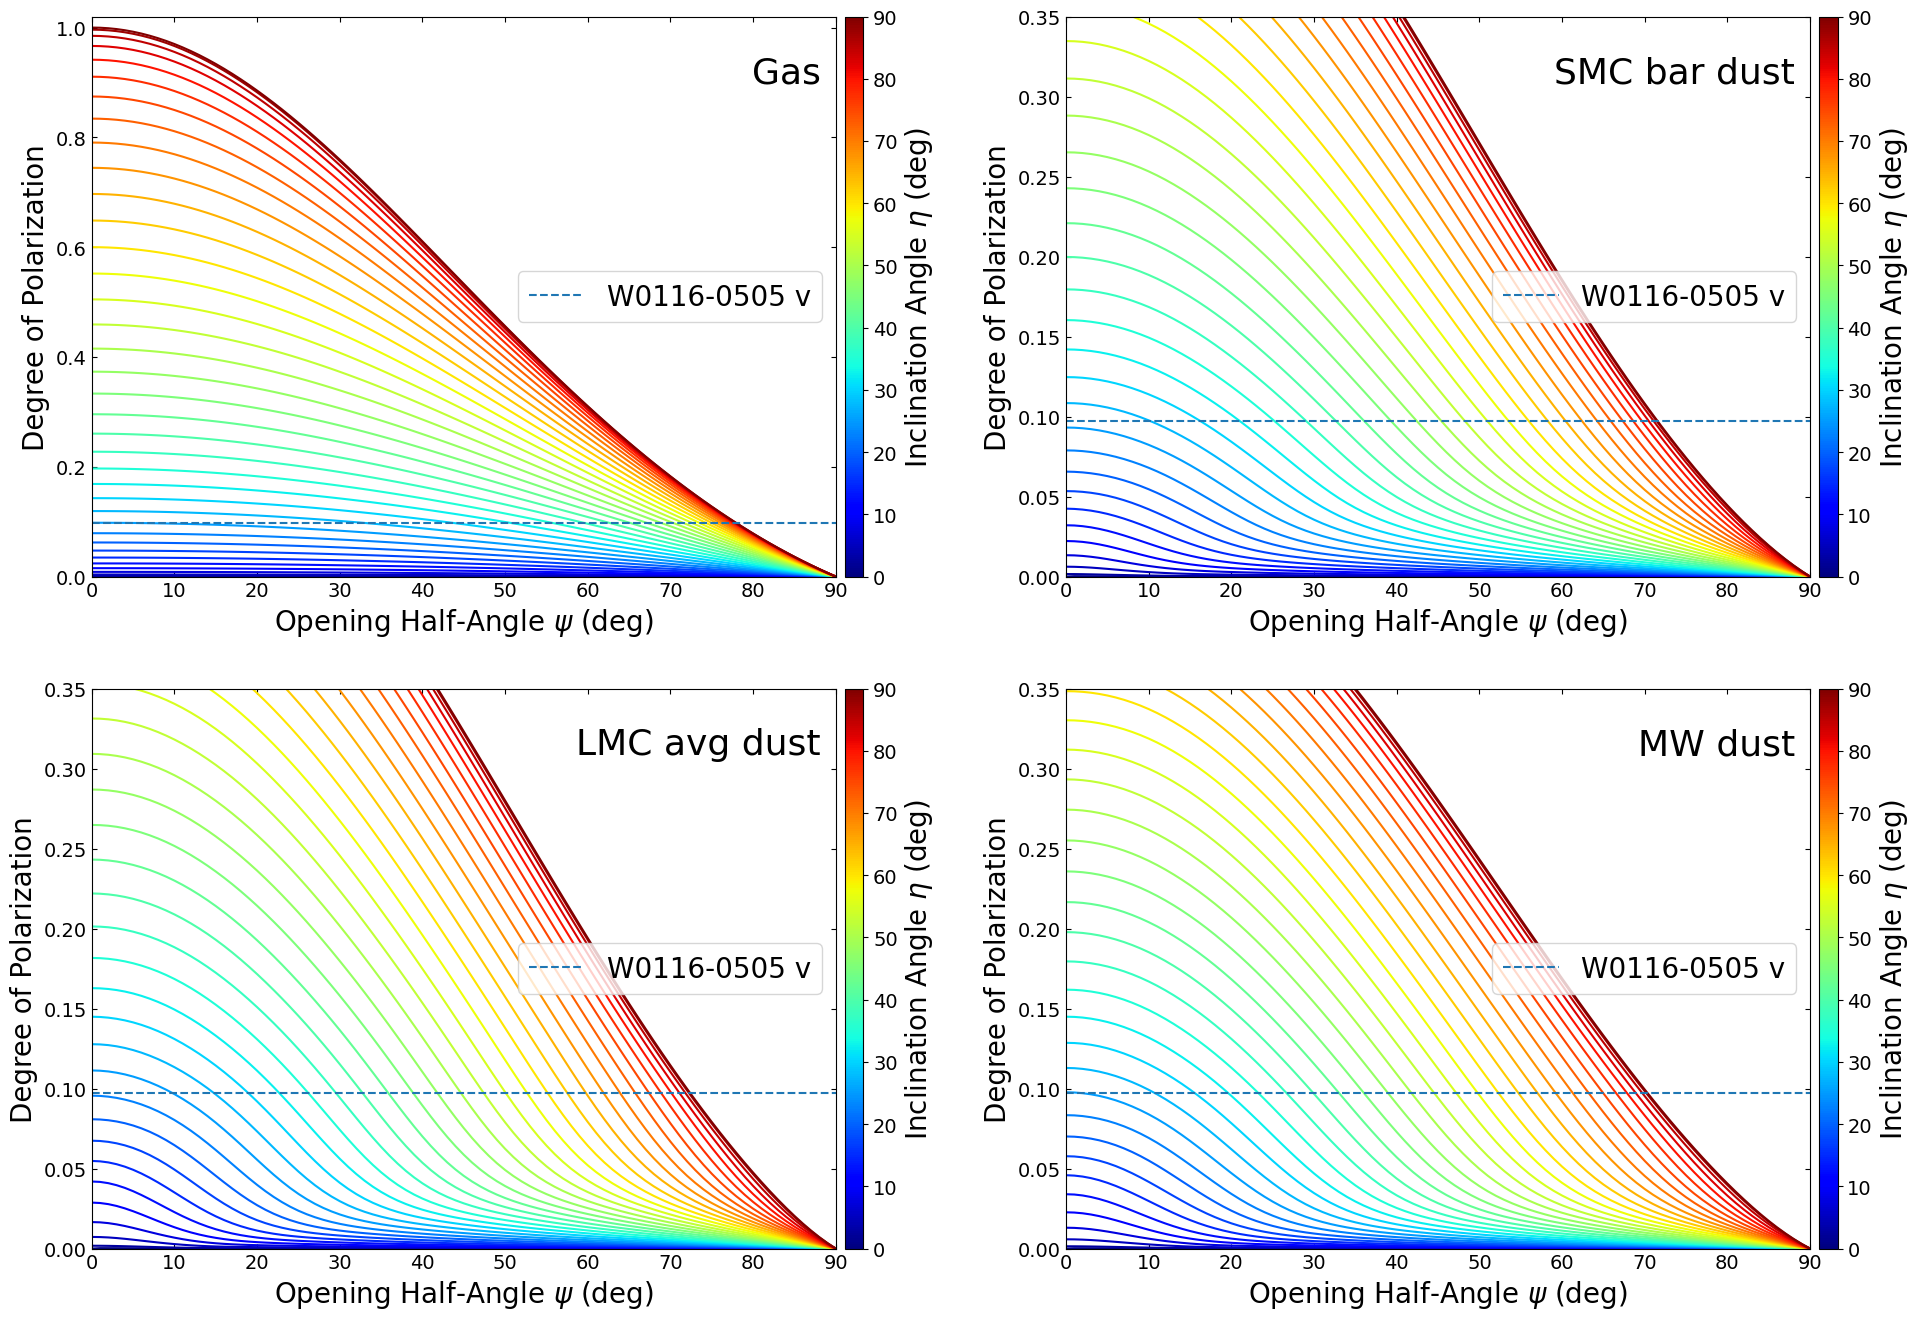

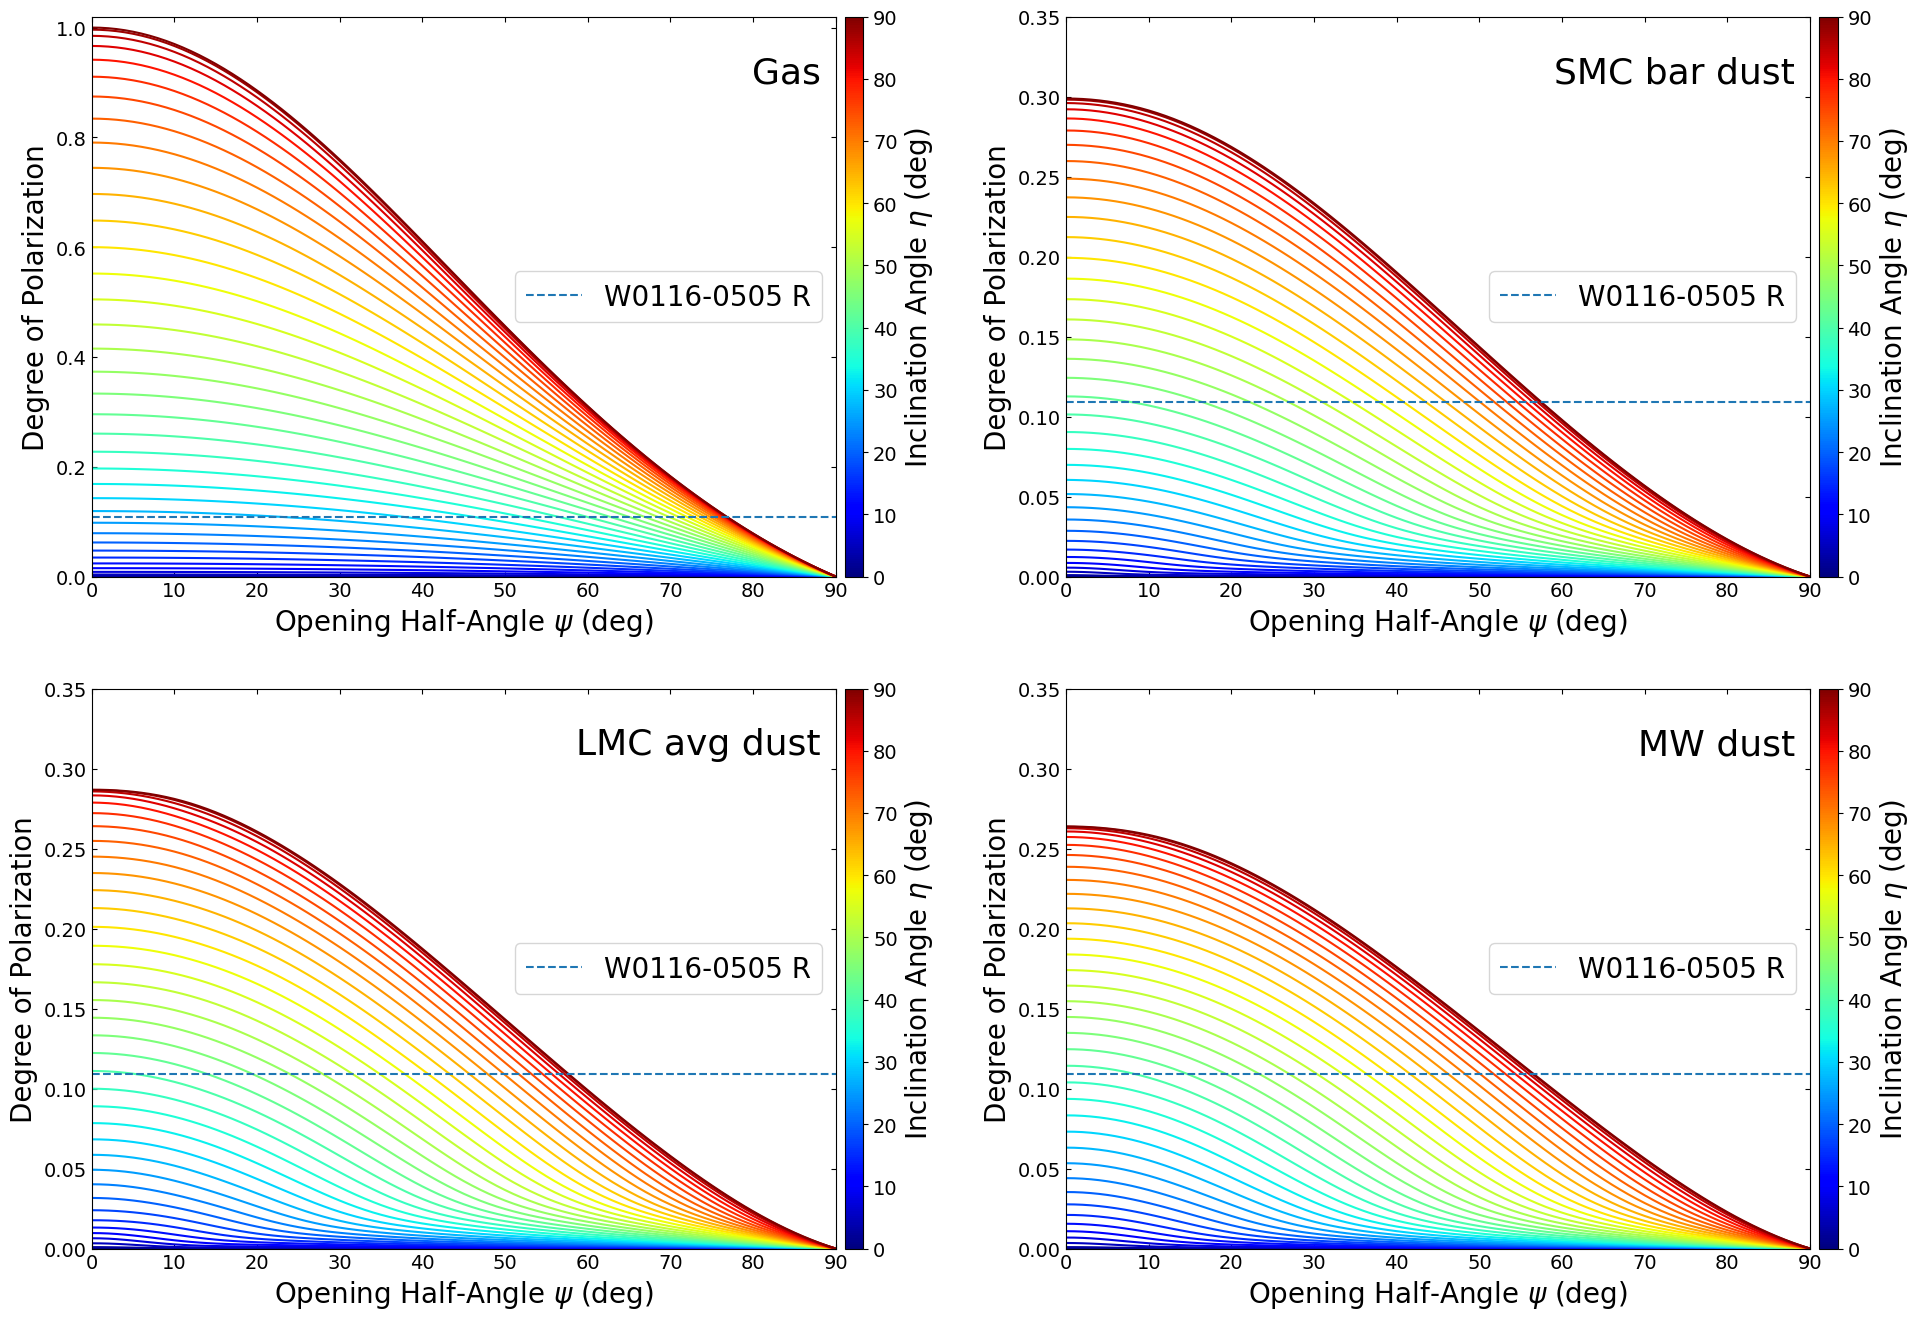

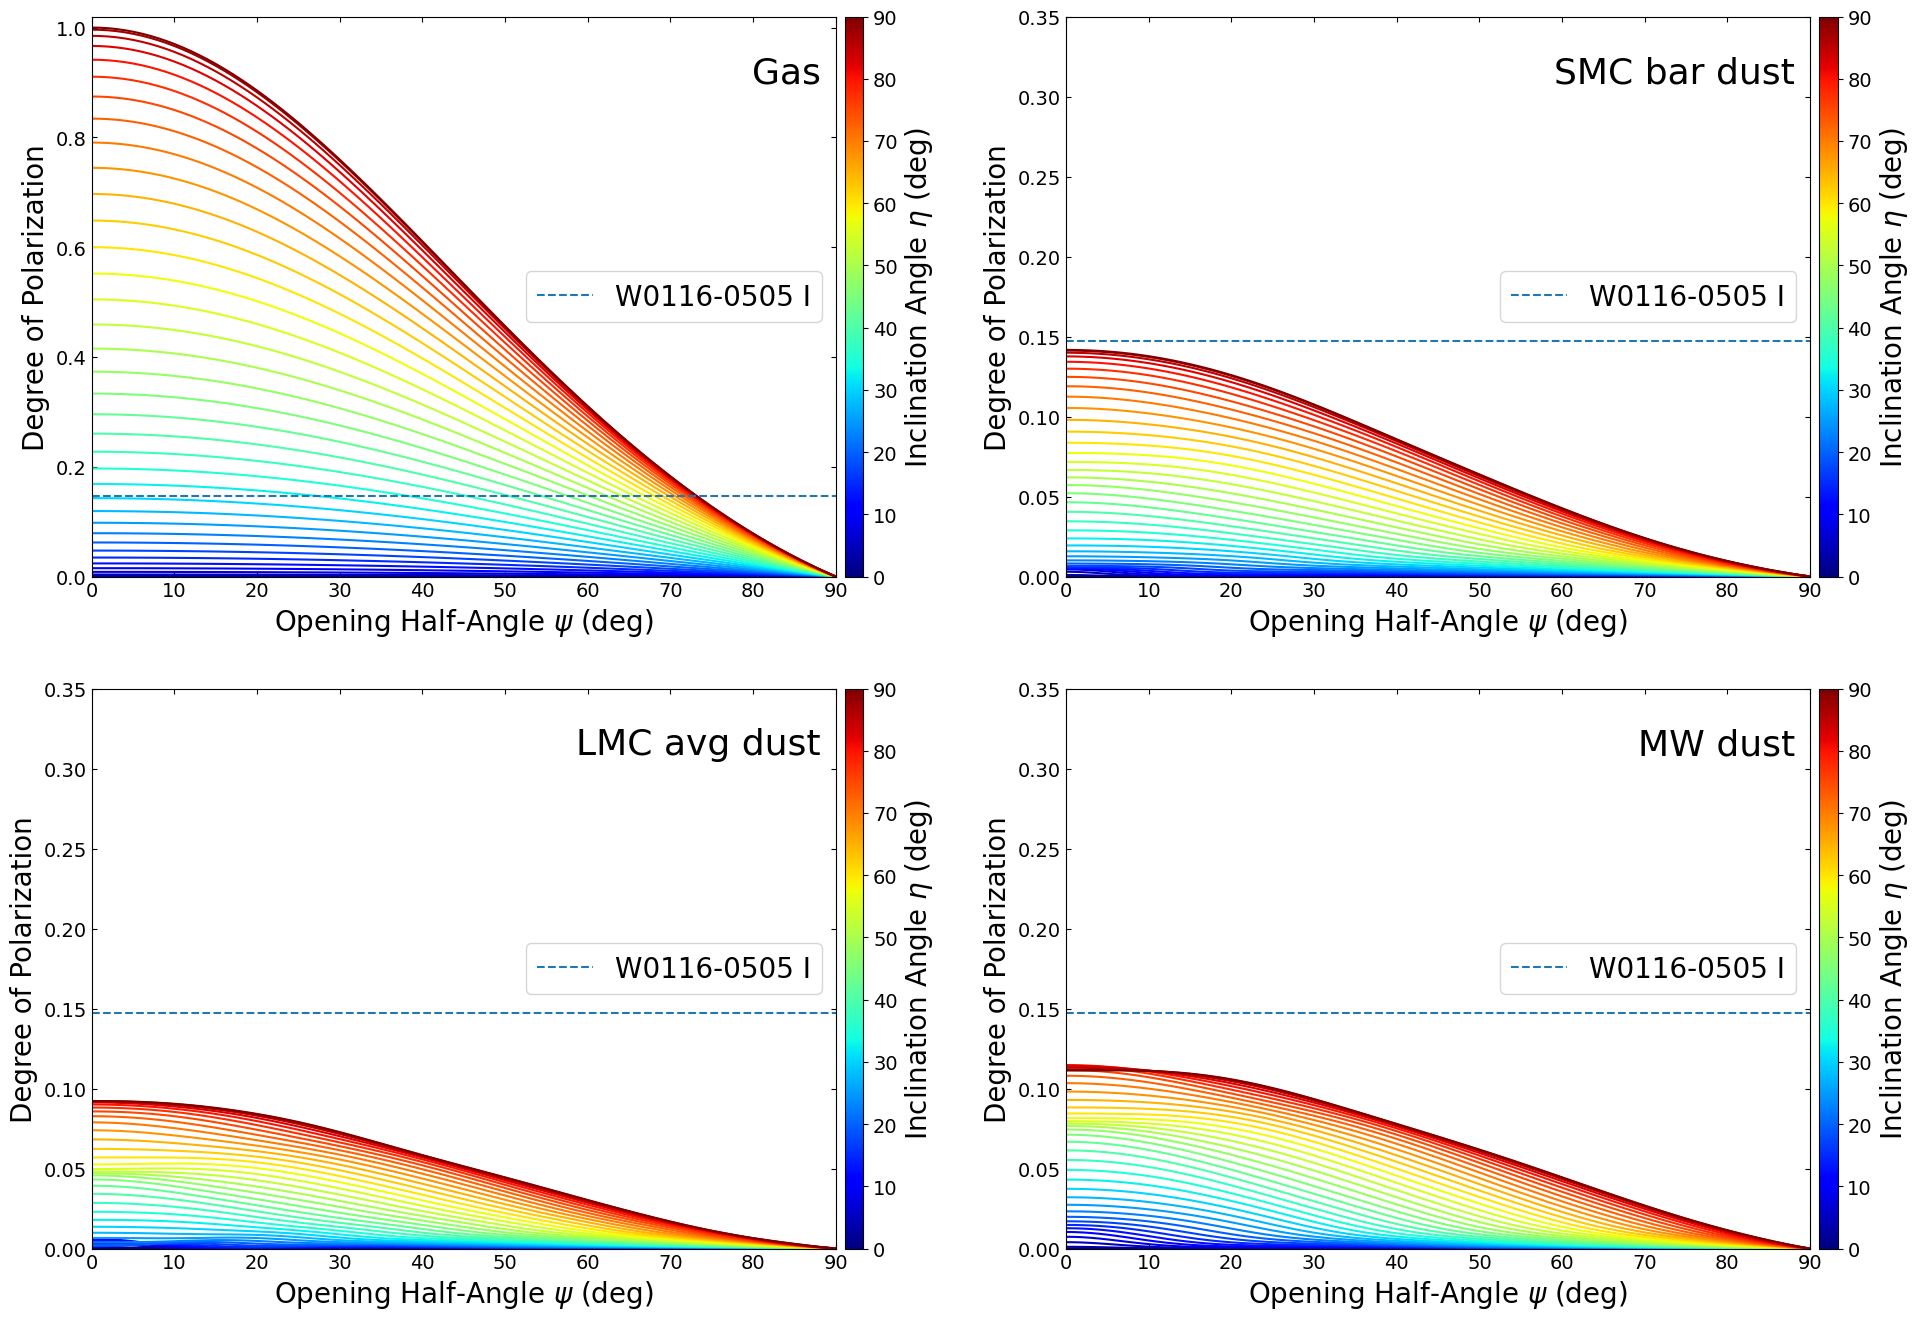

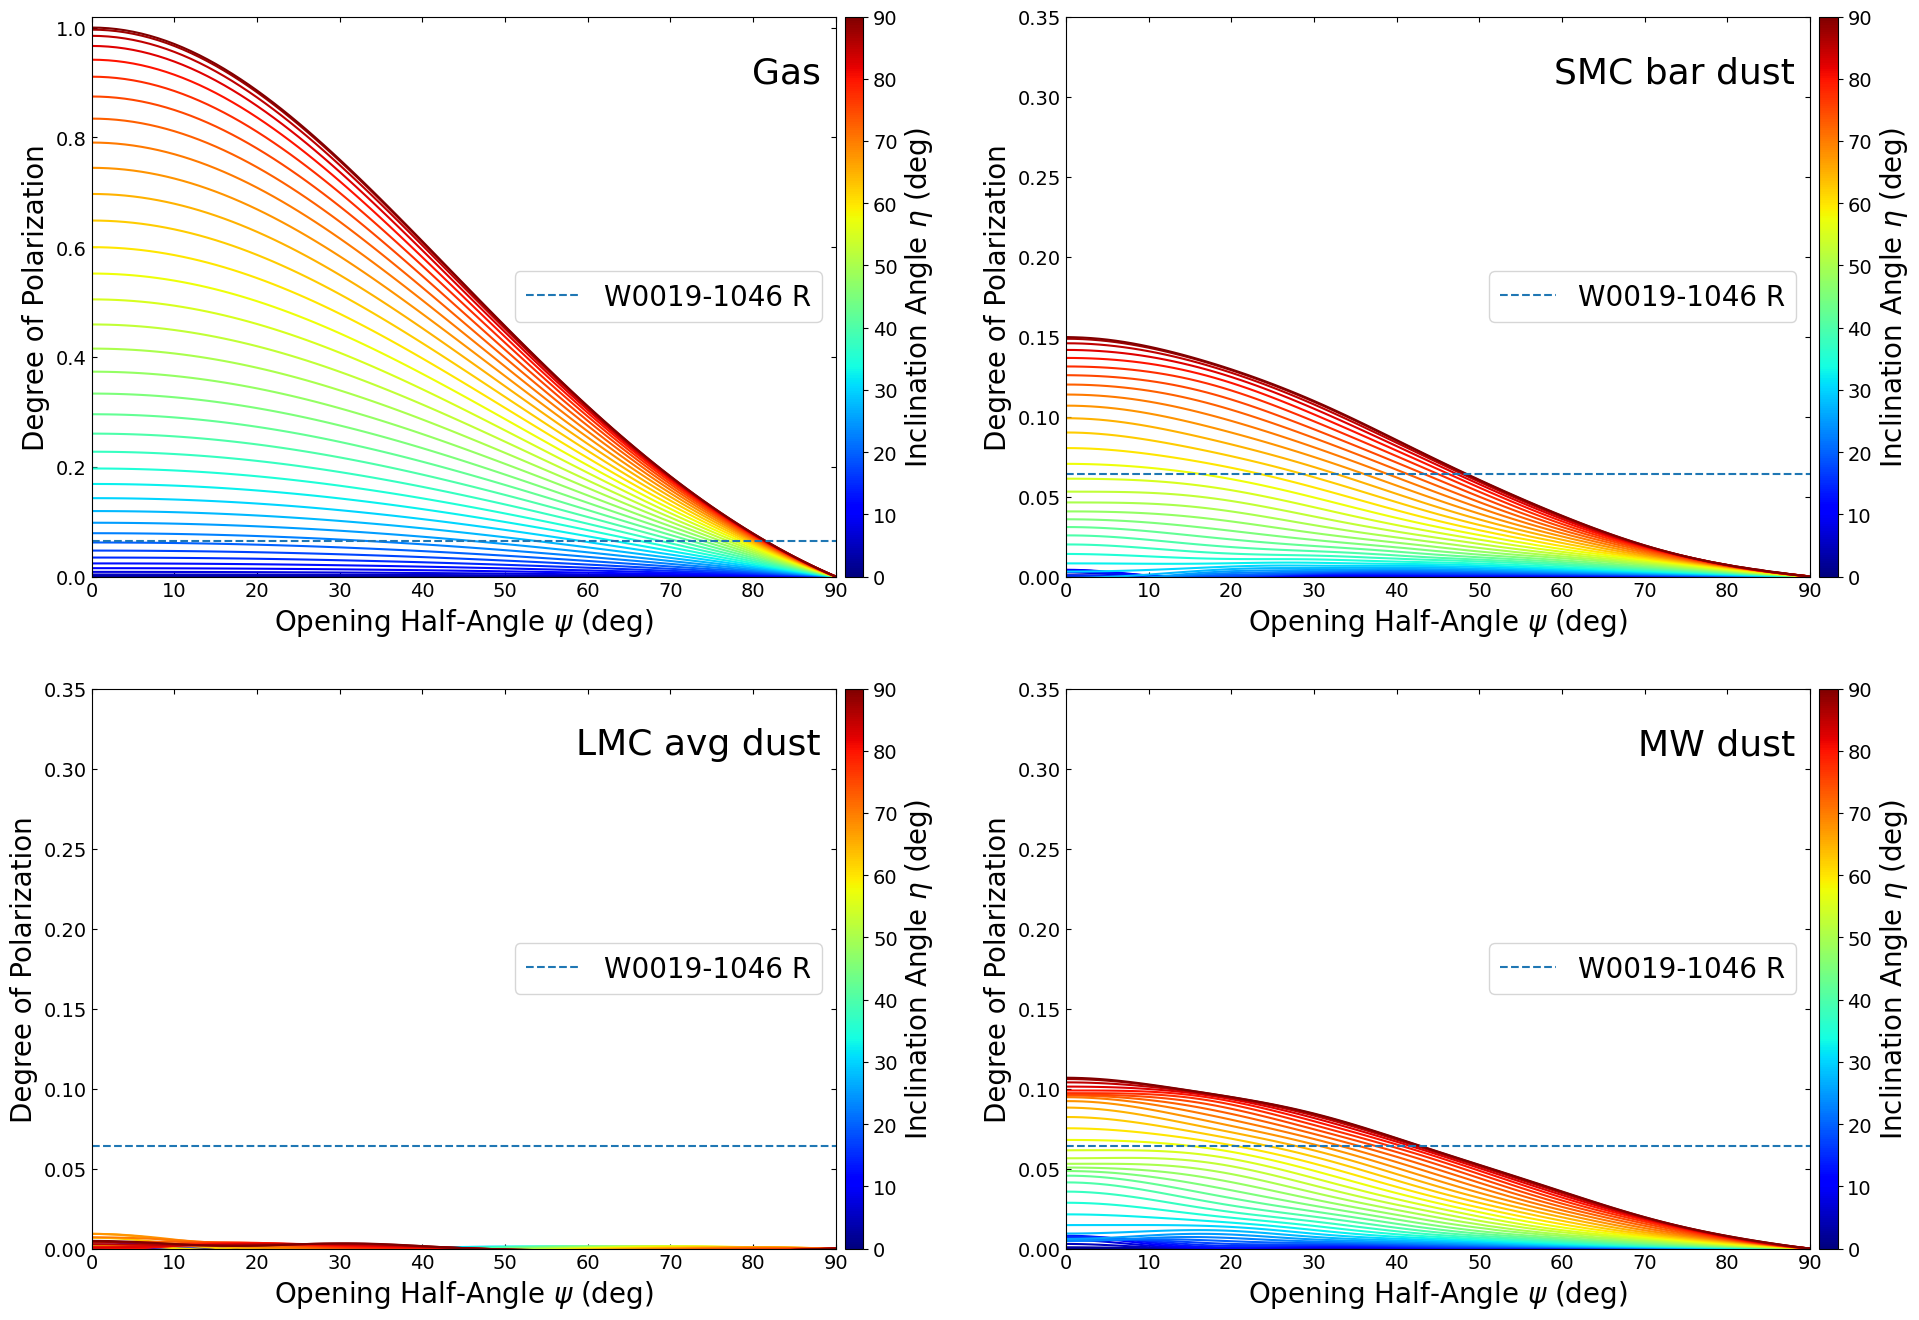

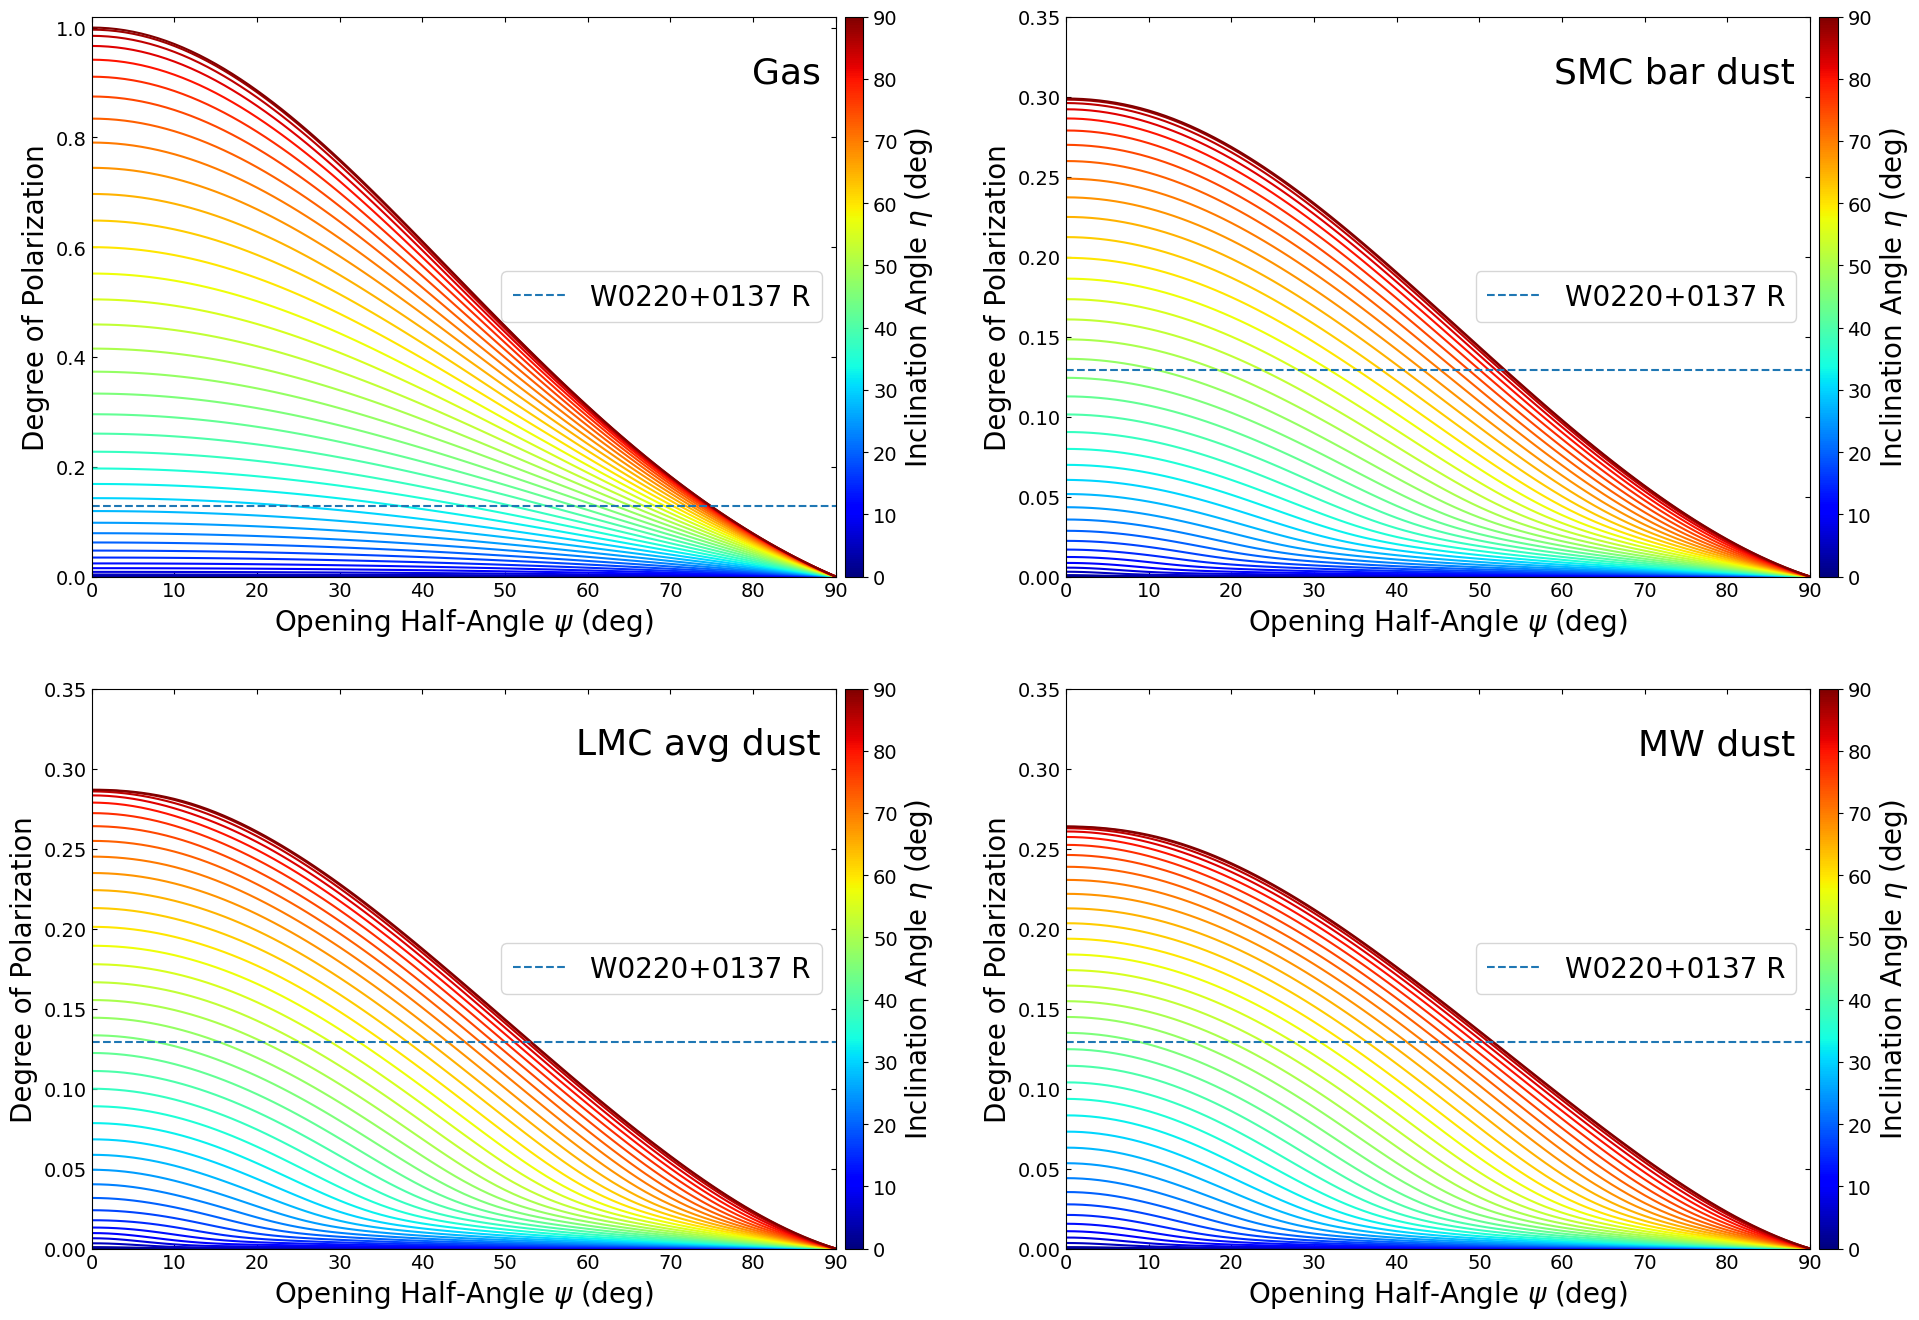

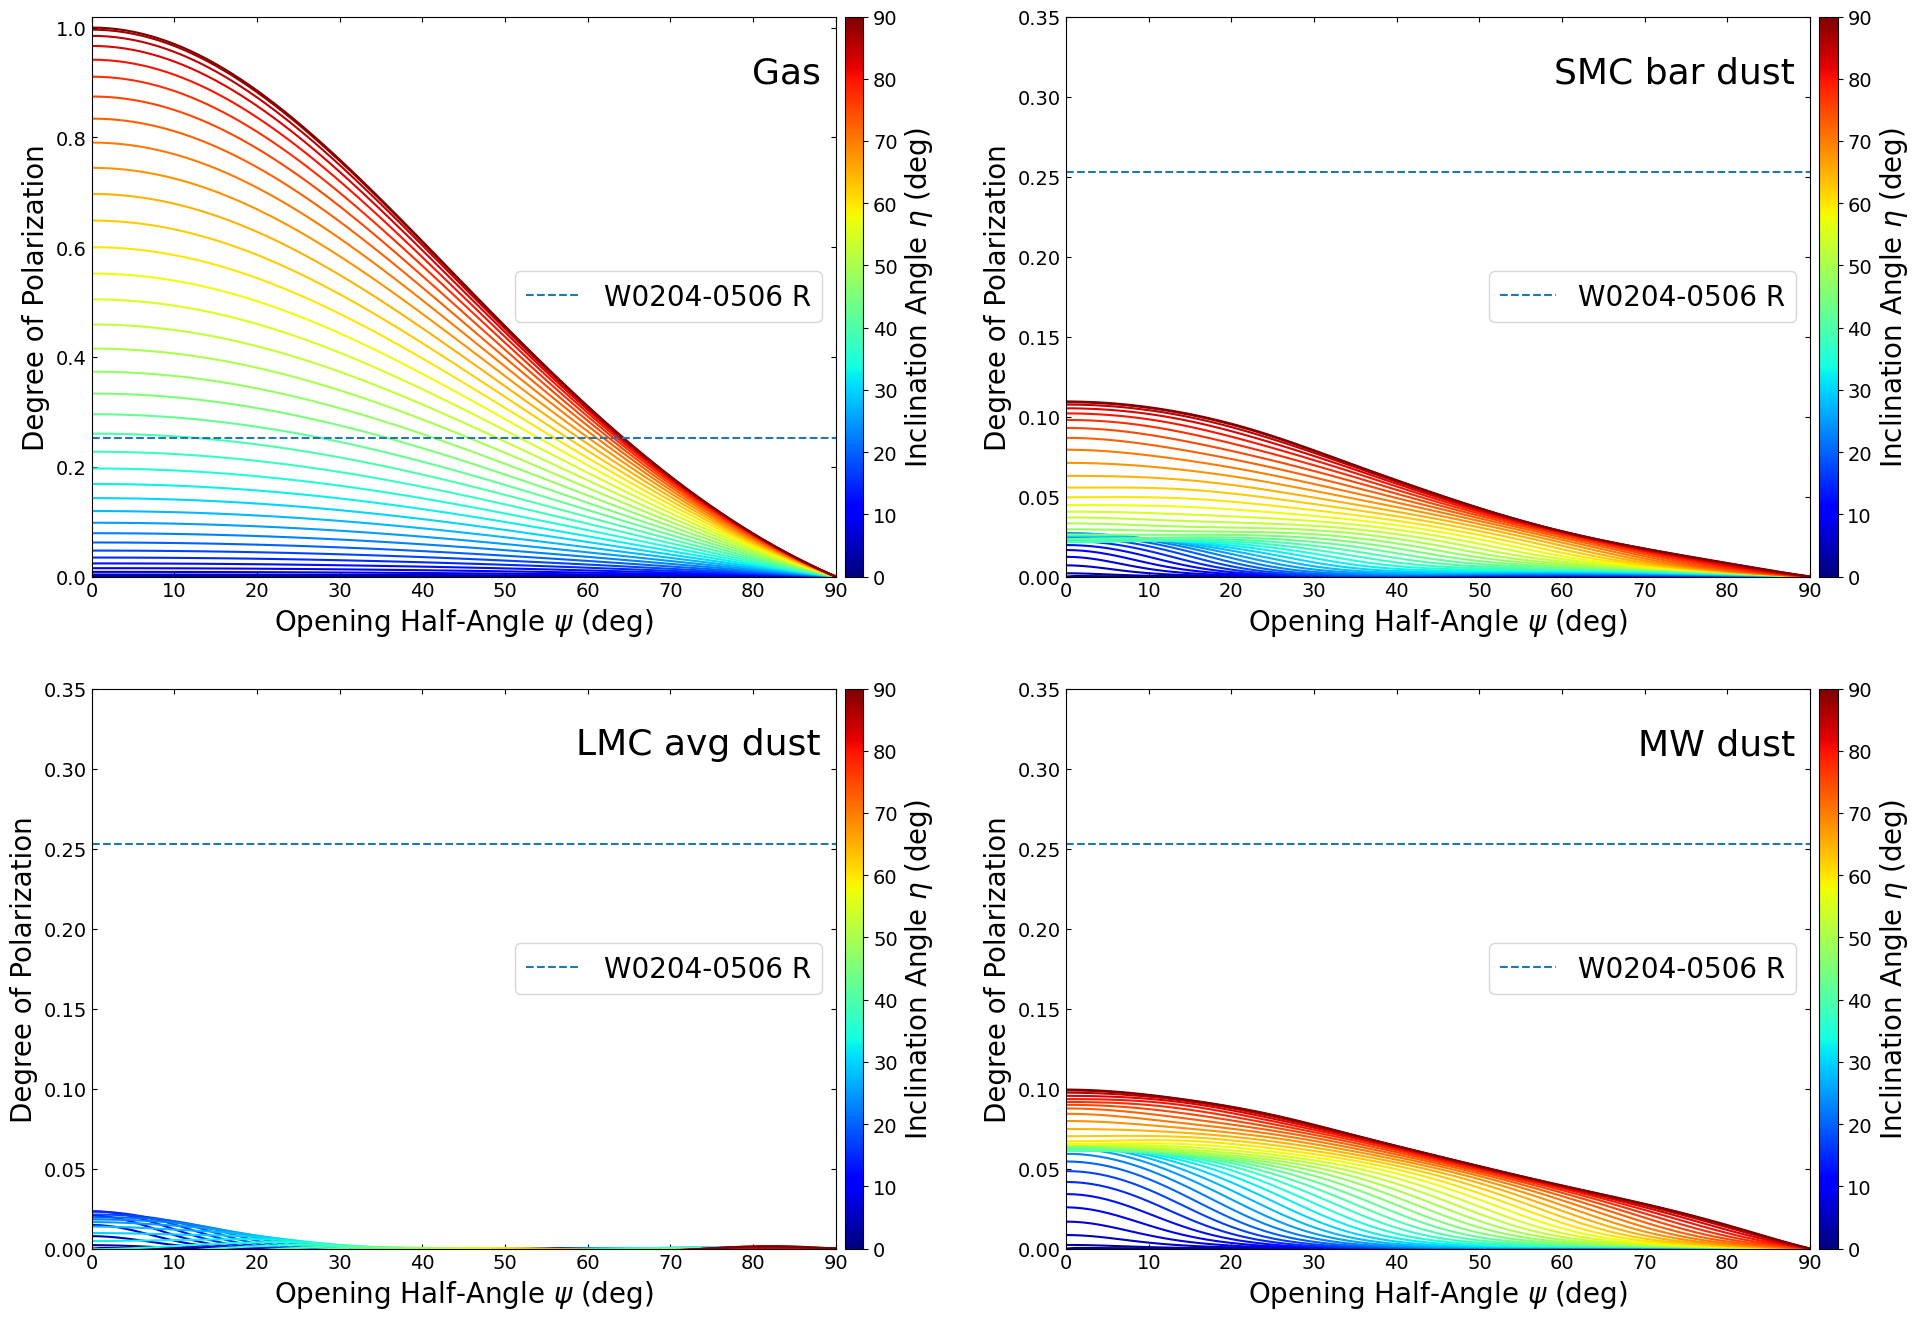

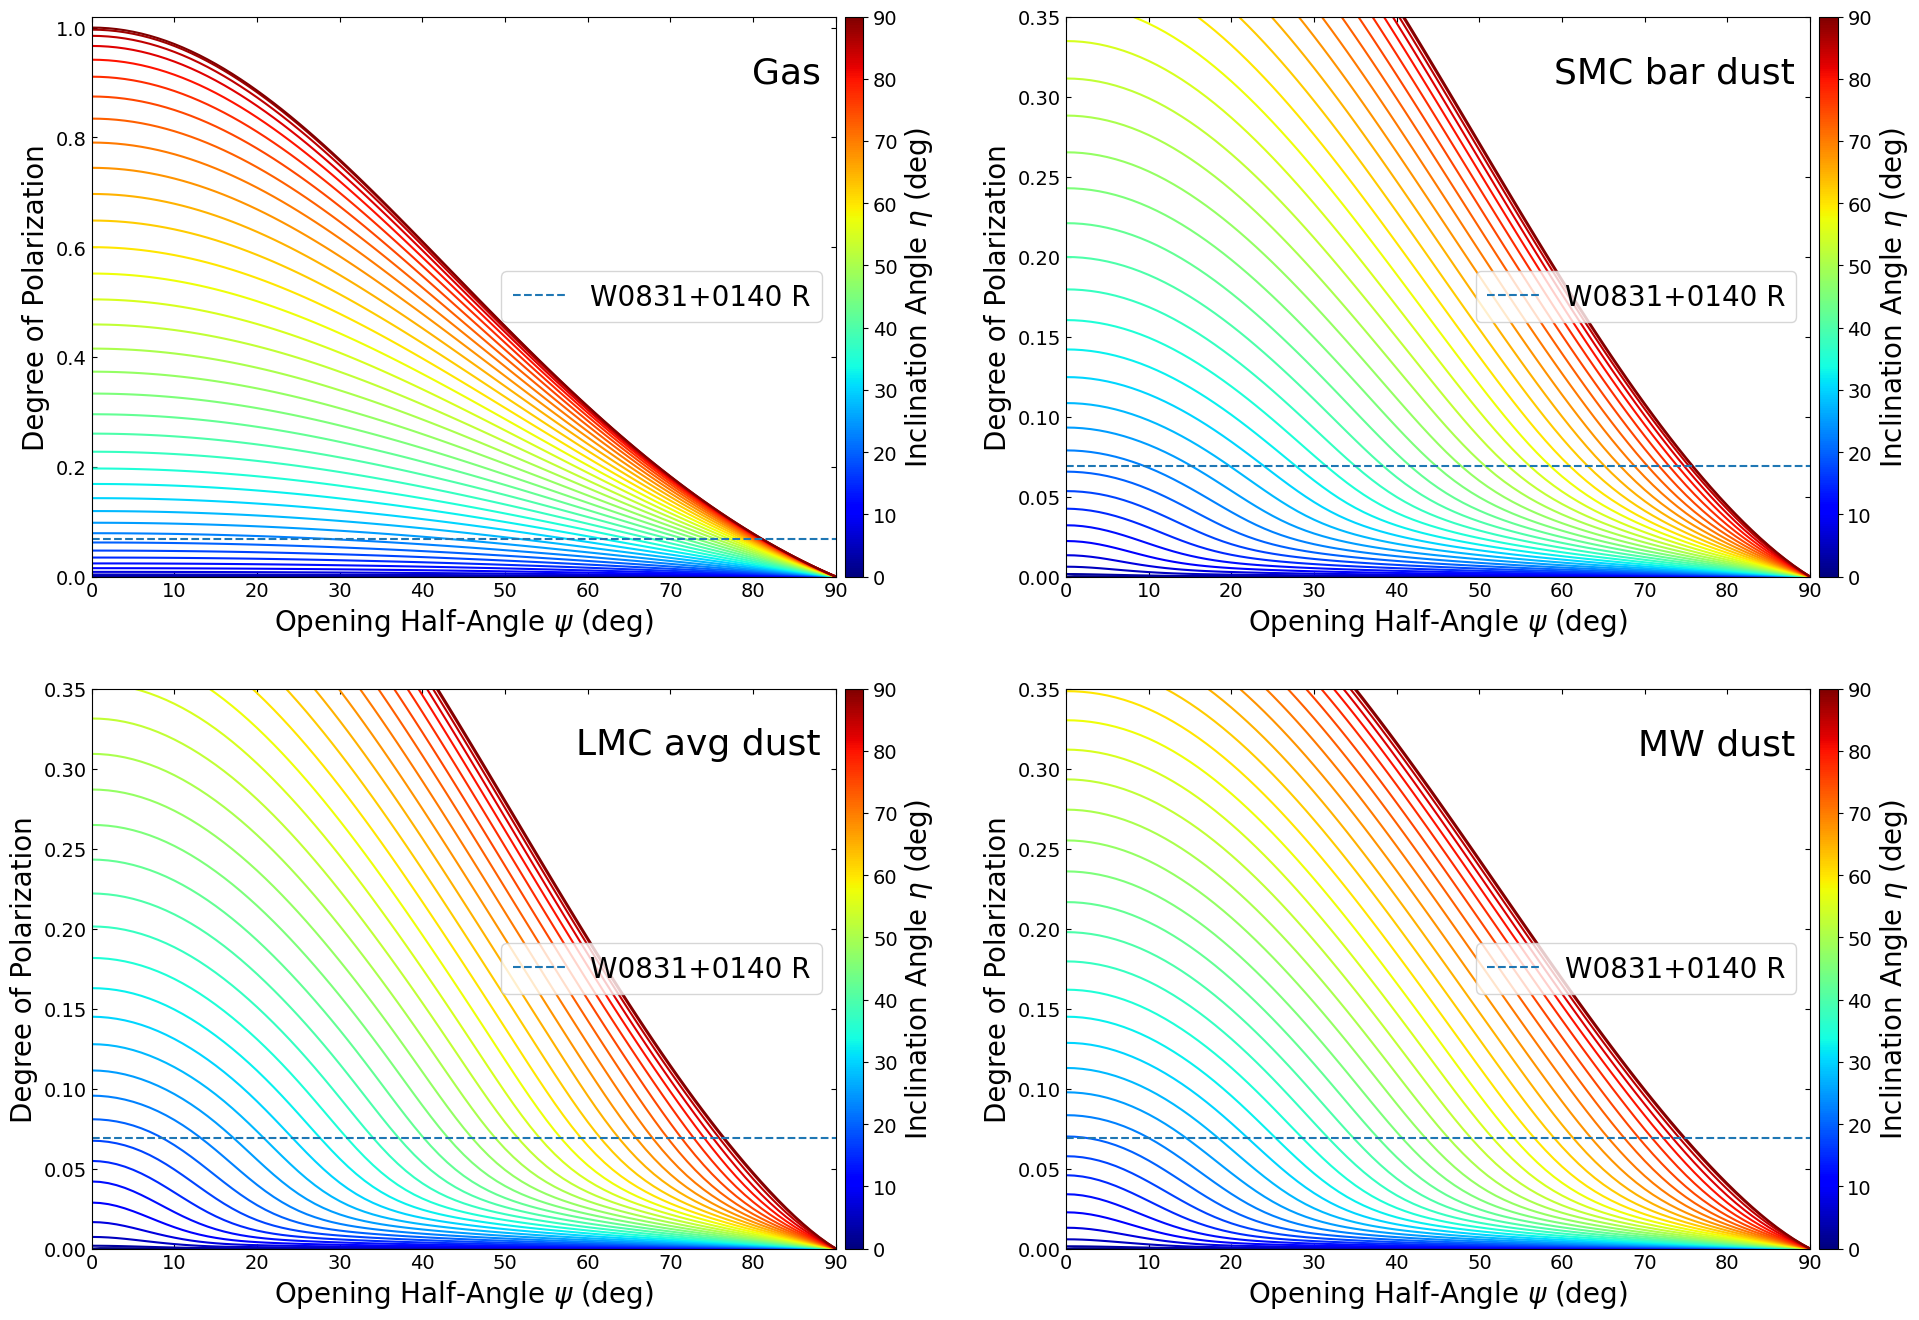

In [9]:
for wid in pol_data.keys():
    for iband, band in enumerate(pol_data[wid]["bands"]):
        models = read_models(wid, band)
        fig, ax = plt.subplots(2,2,figsize=(24, 16))
        fig.subplots_adjust(wspace=0.1)
        plot_labels = ["Gas", "SMC bar dust", "LMC avg dust", "MW dust"]
        ymax = [1.02, 0.35, 0.35, 0.35]
        lam = band_centers[band]/(1+pol_data[wid]['z'])
        pobjs = get_pobjs(lam)
        for k, model in enumerate(models):
            plot_pol(model, pobjs[k], plot_fname=None, plot_label=plot_labels[k], ymax=ymax[k], fig=fig, ax=ax.flatten()[k])
            # #The detected polarization fraction. 
            # for key in pfrac.keys():
            puse = pol_data[wid]['pfrac'][iband]
            ax.flatten()[k].plot([0, 90], [puse, puse], '--', label=wid+" "+band)
            ax.flatten()[k].legend(loc=7, fontsize=20)
        plt.savefig("combined_pol.{}.{}.png".format(wid,band), dpi=100, bbox_inches='tight', transparent=False, facecolor='white')

In [10]:
#Measured polarizations corrected for host contamination (so just AGN polarization fraction). 
pfrac_hc = dict()
pfrac_hc['W0116-0505'] = 0.11/0.99
pfrac_hc['W0019-1046'] = 0.06/0.70
pfrac_hc['W0220+0137'] = 0.13/0.72
pfrac_hc['W0204-0506'] = 0.25/0.95

In [11]:
for key in pfrac_hc.keys():
    print(key, pfrac_hc[key])

W0116-0505 0.11111111111111112
W0019-1046 0.08571428571428572
W0220+0137 0.18055555555555558
W0204-0506 0.2631578947368421


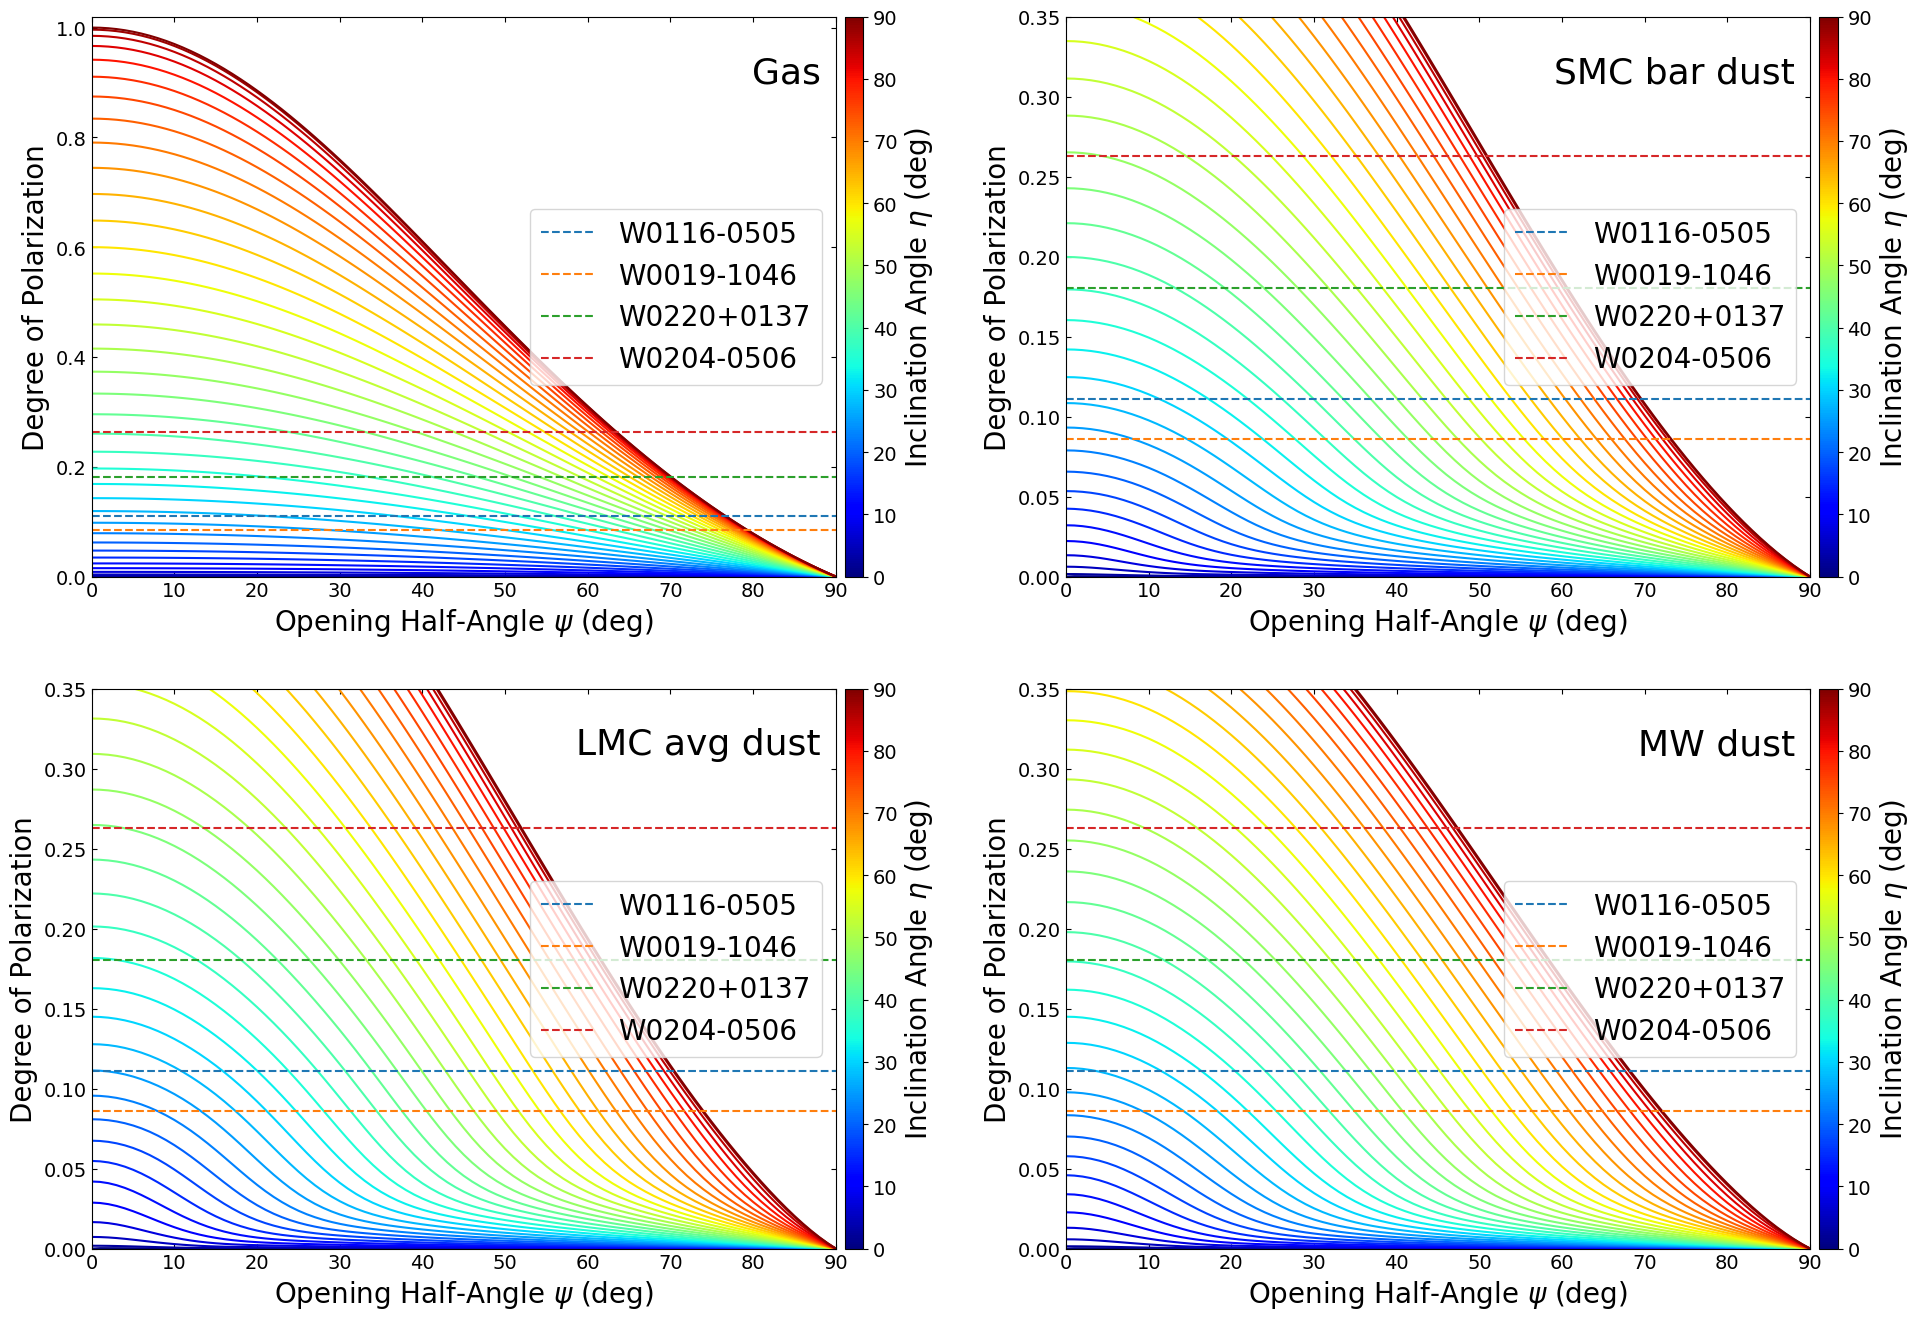

In [12]:
fig, ax = plt.subplots(2,2,figsize=(24, 16))
fig.subplots_adjust(wspace=0.1)
plot_labels = ["Gas", "SMC bar dust", "LMC avg dust", "MW dust"]
ymax = [1.02, 0.35, 0.35, 0.35]
for k, model in enumerate(models):
    plot_pol(model, pobjs[k], plot_fname=None, plot_label=plot_labels[k], ymax=ymax[k], fig=fig, ax=ax.flatten()[k])
    #The detected polarization fraction. 
    for key in pfrac_hc.keys():
        puse = pfrac_hc[key]
        ax.flatten()[k].plot([0, 90], [puse, puse], '--', label=key)
    ax.flatten()[k].legend(loc=7, fontsize=20)
plt.savefig("combined_pol_hc.png", dpi=100, bbox_inches='tight', transparent=False, facecolor='white')